## Violations feature analysis

> Written by Jess Breda August 2023

For this notebook, I am determining which features describing violations should be included in the model. This is polishing the work from `multiclass_dev_PWM`. I will be looking at how different filters of violation history influence a mutli-class logistic regression model.

In [1]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import KFold, train_test_split

from generate_design_matrix import *
from get_rat_data import *
from multiclass_logistic_regression import *

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

### Data Load 


In [2]:
ANIMAL_ID = "W065"
df = get_rat_viol_data(animal_ids=ANIMAL_ID)

returning data for W065


In [11]:
train_df, test_df = session_train_test_split(df, test_size=0.25, random_state=75)
print(f"N train sessions: {len(train_df.session.unique())}")
print(f"N test sessions: {len(test_df.session.unique())}")

N train sessions: 149
N test sessions: 50


In [16]:
def fit_and_store(params, verbose=False):
    # Initialize an empty DataFrame
    df_list = []

    for sigma in params["sigmas"]:
        for idx, taus in enumerate(params["tausL"]):
            print(
                f"fitting model {params['names'][idx]} with sigma {sigma} and taus {taus}"
            )
            X_train, Y_train = generate_design_mat_and_labels(
                train_df, columns_to_filter=["violation"], taus=taus, verbose=verbose
            )
            X_test, Y_test = generate_design_mat_and_labels(
                test_df, columns_to_filter=["violation"], taus=taus, verbose=verbose
            )

            W_fit = fit_multiclass(X_train, Y_train, sigma=sigma, disp=verbose)
            nll = multiclass_logistic_cost(W_fit, X_test.to_numpy(), Y_test, sigma=None)

            # Create a DataFrame for this iteration
            iter_df = pd.DataFrame(
                {
                    "model_name": [params["names"][idx]],
                    "nll": [nll],
                    "sigma": [sigma],
                    "features": [list(X_train.columns)],
                    "weights": [W_fit.tolist()],  # Convert numpy array to list
                }
            )

            # Append the DataFrame to the list
            df_list.append(iter_df)

    # Concatenate all the DataFrames in the list
    fitting_info_df = pd.concat(df_list, ignore_index=True)
    return fitting_info_df

In [17]:
params = {
    "sigmas": [0, 0.5, 1, 1.5, 3, 5, 10, 20],
    "tausL": [
        [None],
        [3],
        [10],
        [30],
        [100],
        [3, 10],
        [3, 30],
        [10, 100],
        [30, 100],
        [3, 10, 30],
        [3, 10, 30, 100],
    ],
}
params = generate_model_names(params)
fitting_info_df = fit_and_store(params)

fitting model base with sigma 0 and taus [None]
fitting model t_3 with sigma 0 and taus [3]
fitting model t_10 with sigma 0 and taus [10]
fitting model t_30 with sigma 0 and taus [30]
fitting model t_100 with sigma 0 and taus [100]
fitting model t_3_10 with sigma 0 and taus [3, 10]
fitting model t_3_30 with sigma 0 and taus [3, 30]
fitting model t_10_100 with sigma 0 and taus [10, 100]
fitting model t_30_100 with sigma 0 and taus [30, 100]
fitting model t_3_10_30 with sigma 0 and taus [3, 10, 30]
fitting model t_3_10_30_100 with sigma 0 and taus [3, 10, 30, 100]
fitting model base with sigma 0.5 and taus [None]
fitting model t_3 with sigma 0.5 and taus [3]
fitting model t_10 with sigma 0.5 and taus [10]
fitting model t_30 with sigma 0.5 and taus [30]
fitting model t_100 with sigma 0.5 and taus [100]
fitting model t_3_10 with sigma 0.5 and taus [3, 10]
fitting model t_3_30 with sigma 0.5 and taus [3, 30]
fitting model t_10_100 with sigma 0.5 and taus [10, 100]
fitting model t_30_100 wit

In [18]:
def find_best_sigma(fitting_info_df):
    # Group by 'model_name' and find the row with minimum 'nll' for each group
    idx_best_sigma = fitting_info_df.groupby("model_name")["nll"].idxmin()

    # Use these indices to find the corresponding best 'sigma' values
    best_sigma_df = fitting_info_df.loc[idx_best_sigma][["model_name", "sigma", "nll"]]

    return best_sigma_df

In [19]:
best_sigma_df = find_best_sigma(fitting_info_df)

In [20]:
def plot_best_fit(best_sigma_df):
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(
        x="model_name", y="nll", data=best_sigma_df, ax=ax, order=params["names"]
    )
    plt.xticks(rotation=90)

    for p, sigma in zip(ax.patches, best_sigma_df["sigma"]):
        ax.annotate(
            f"σ={sigma}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="baseline",
            xytext=(0, 10),
            textcoords="offset points",
        )
    sns.despine()

    ax.set(
        ylabel="Test Negative Log Likelihood",
        xlabel="Model",
    )

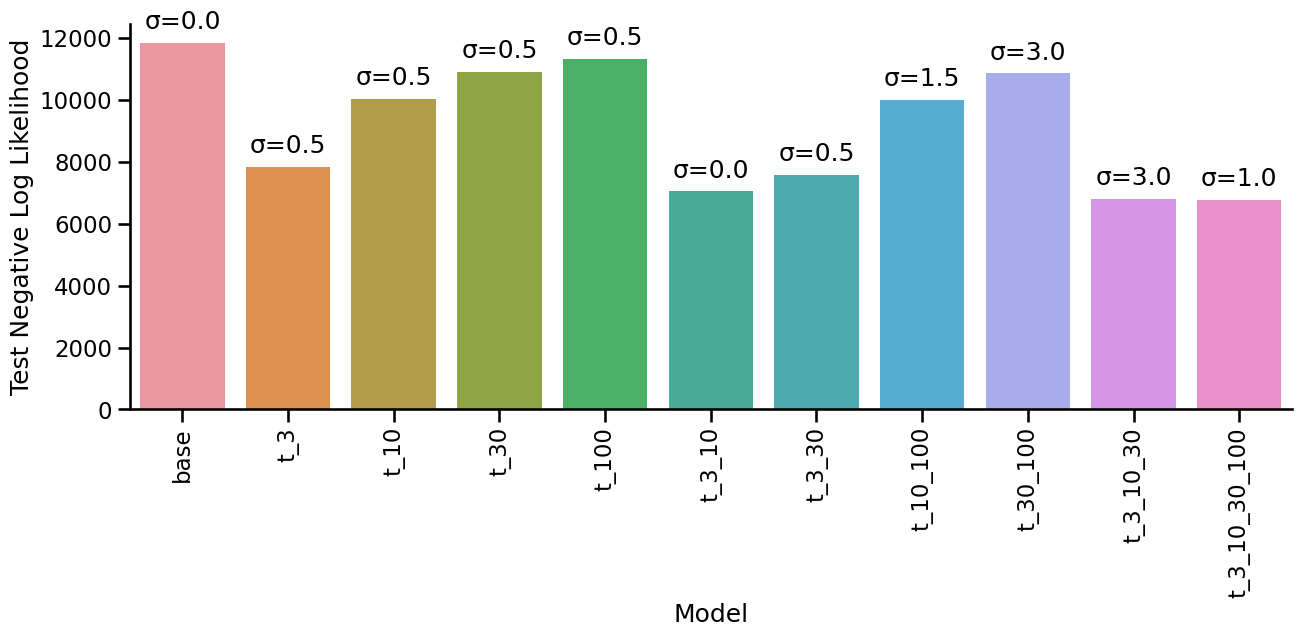

In [21]:
plot_best_fit(best_sigma_df)

In [22]:
def plot_class_weights(feature_names, W_fit, title=""):
    """
    Plot the weights for each feature and class as bar charts.

    Parameters:
    feature_names: list (D)
         column names from design matrix that related
         to features in W_fit
    W_fit : np.ndarray (D x C)
        weights obtained after optimization (D x C)
    title : str (default: "")
        title for the plot
    """

    # Extract shape details
    D, C = W_fit.shape
    classes = ["L", "R", "V"]

    # Prepare data for Seaborn
    weight_data = []
    for c in range(C):
        for d in range(D):
            weight_data.append(
                {
                    "Weight": W_fit[d, c],
                    "Feature": feature_names[d],
                    "Class": classes[c],
                }
            )

    df_weights = pd.DataFrame(weight_data)

    # Plot using Seaborn
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.axhline(y=0, color="black")
    sns.barplot(x="Feature", y="Weight", hue="Class", data=df_weights, ax=ax)
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.title(title)

    return None


def plot_class_weights_from_df(fitting_info_df, model_name):
    row = fitting_info_df.loc[fitting_info_df["model_name"] == model_name].iloc[0]
    features = row["features"]
    weights = np.array(row["weights"])
    plot_class_weights(features, weights, title=model_name)

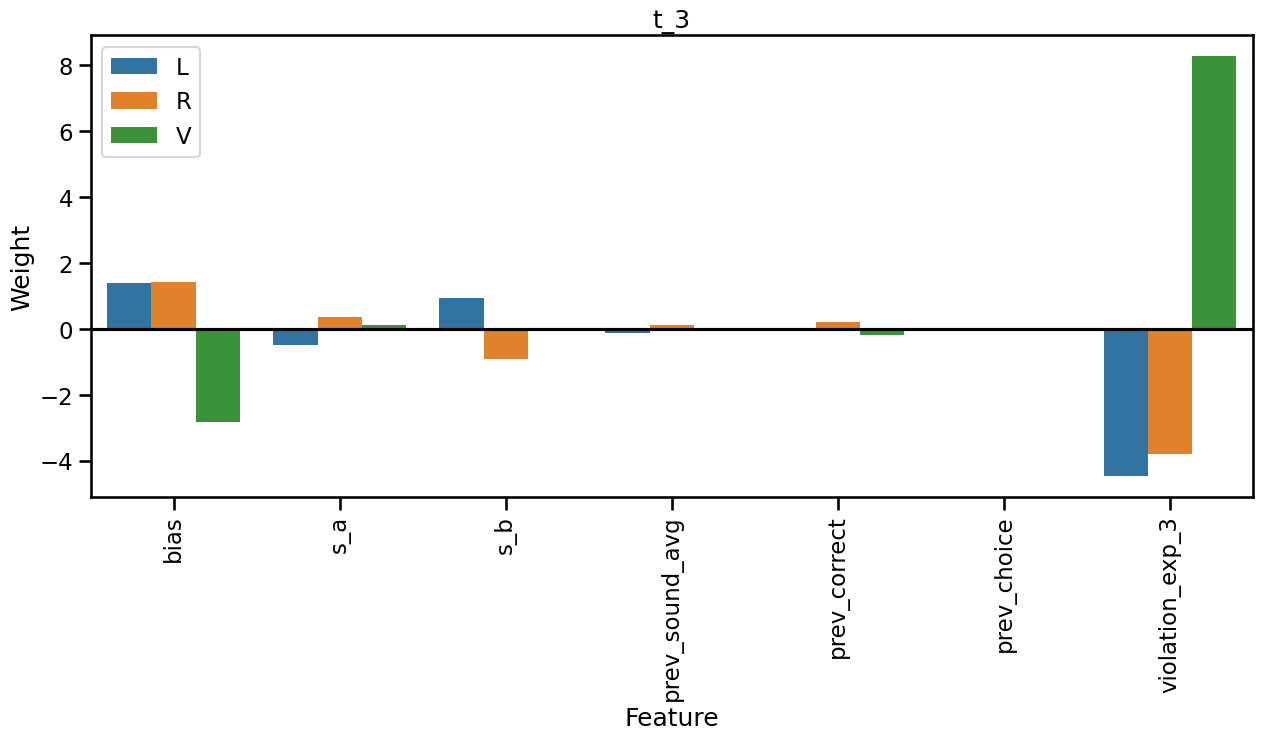

In [24]:
plot_class_weights_from_df(fitting_info_df, "t_3")

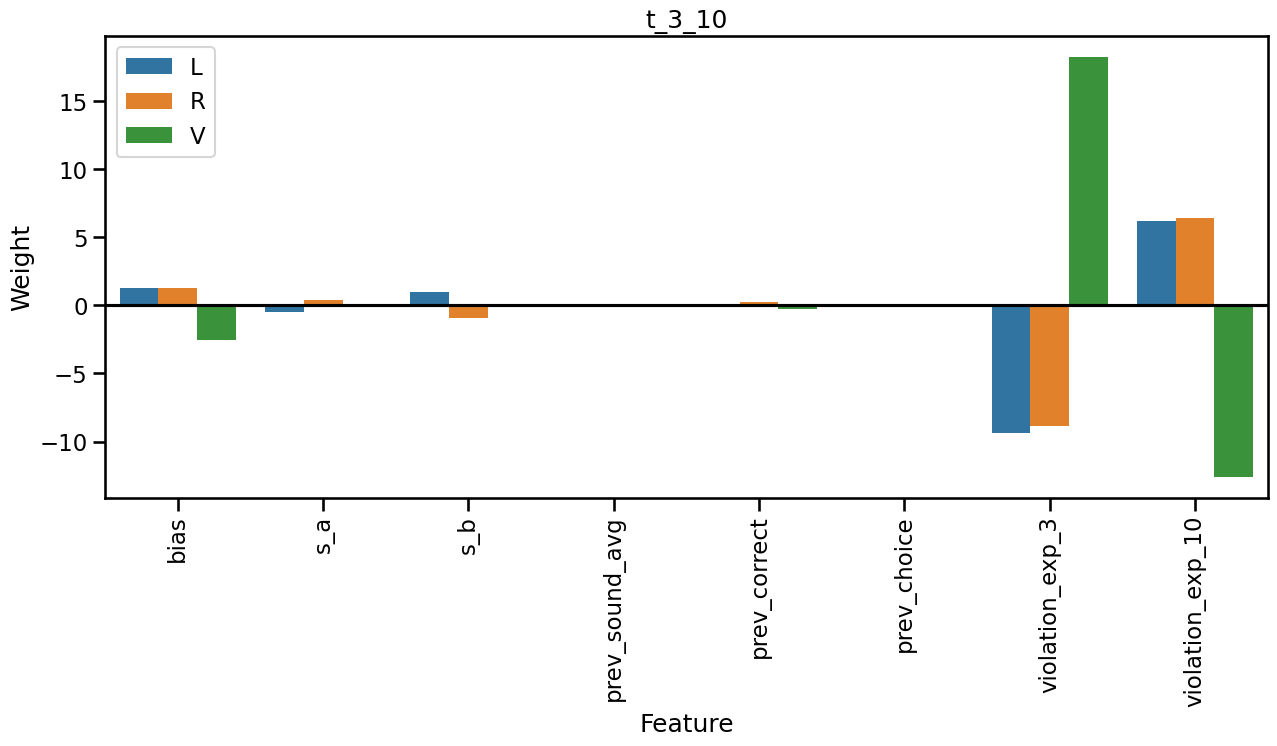

In [23]:
plot_class_weights_from_df(fitting_info_df, "t_3_10")

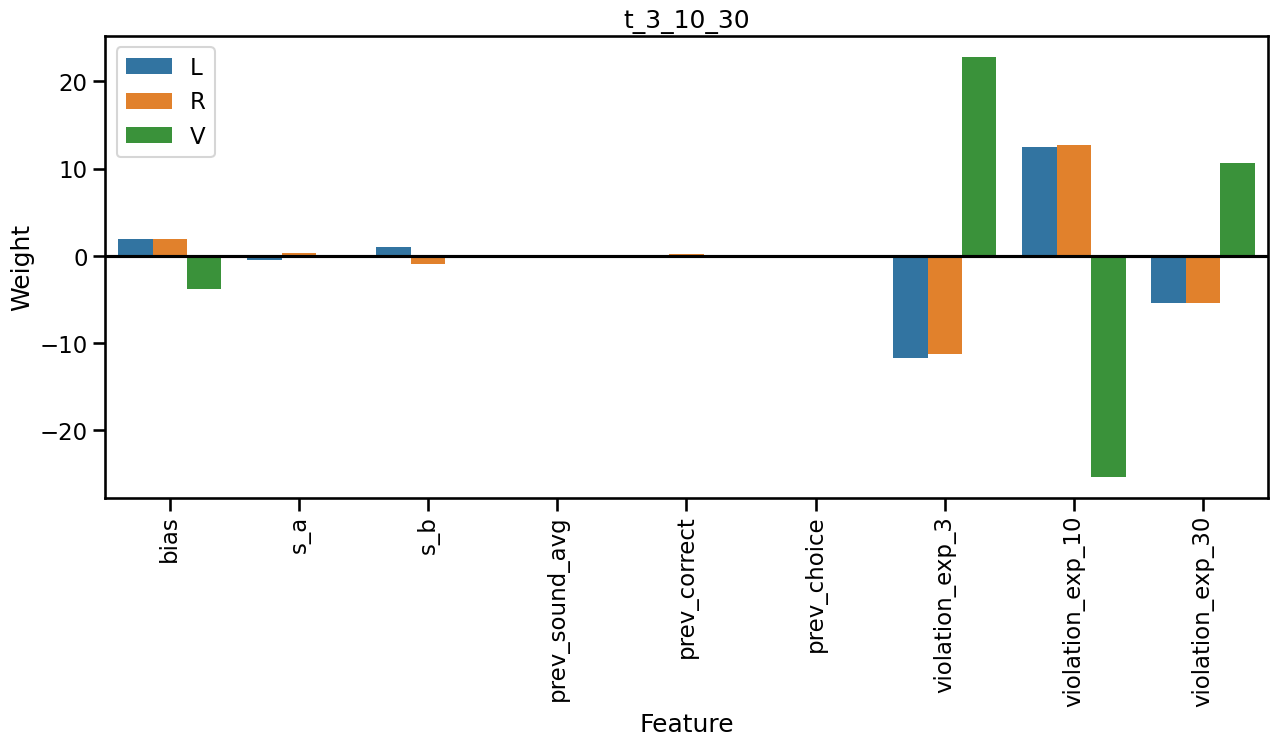

In [25]:
plot_class_weights_from_df(fitting_info_df, "t_3_10_30")

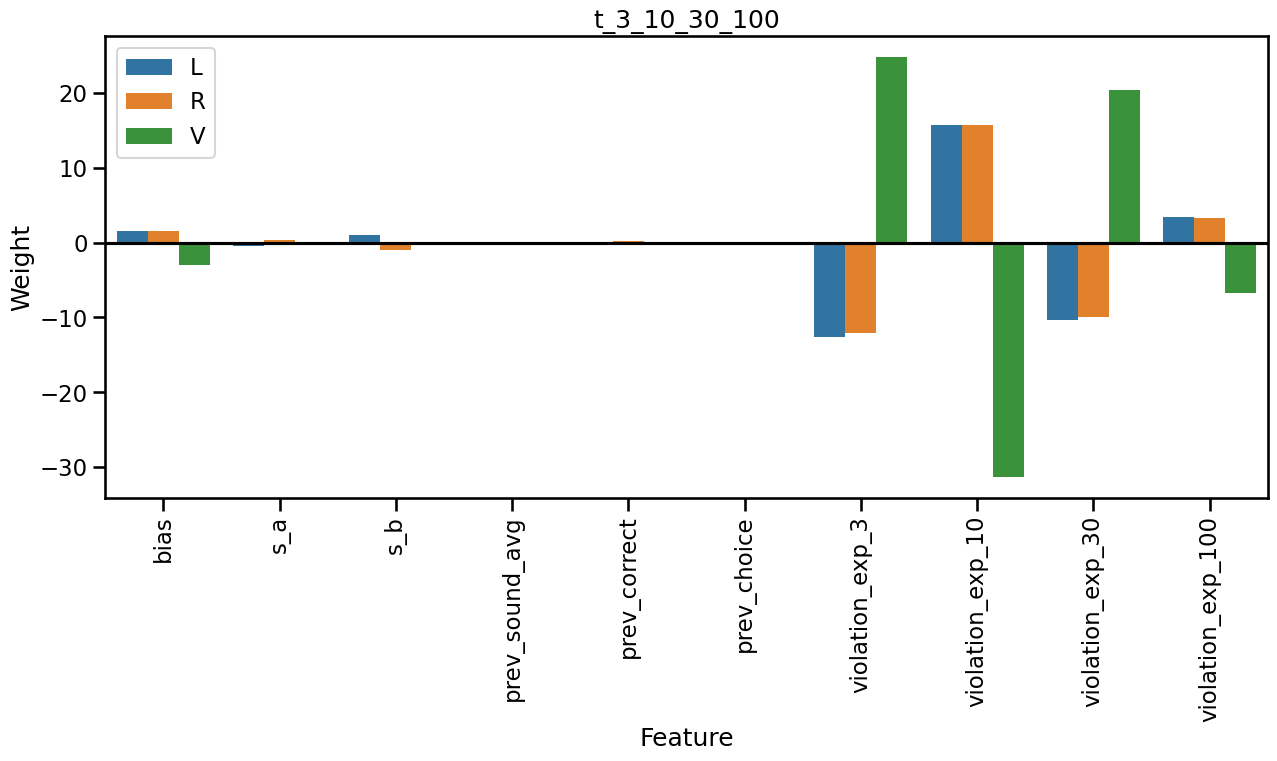

In [27]:
plot_class_weights_from_df(fitting_info_df, "t_3_10_30_100")